In [1]:
'''
    This file provides an example for the use of the shipp package.
    The objective is to size a single storage to satisfy a baseload 
    power production considering an arbitrary power production and price
    time series.
'''

import sys
sys.path.append('../')

from shipp.kernel_pyomo import solve_lp_pyomo
from shipp.components import Storage, Production, TimeSeries

import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

# Global input data for the numerical experiments
n = 364 * 24  # number of time steps
dt = 1 # time step duration [hour]
percent_bl = 0.99 # reliability of the baseload constraint
discount_rate = 0.03 #discount rate
n_year = 20  # Project duration [years]
p_min = 10
p_cost_res = 3000  # USD/MW

# Input data for the storage characteristics
p_cost = 150*1e3  # cost per power capacity for STS [USD/MW]
e_cost = 75 * 1e3 # cost per energy capacity for STS [USD/MWh]
eta = 0.85 #Round trip efficiency for STS

pyo_solver = 'mosek'



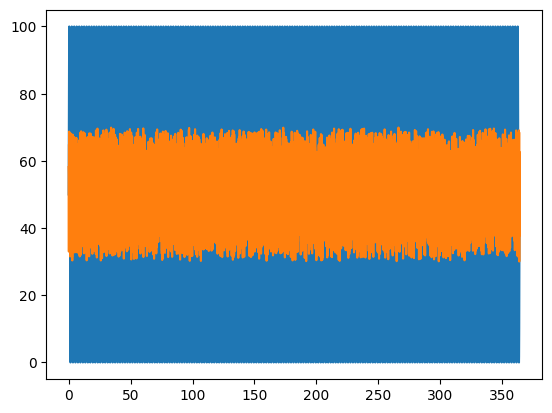

In [11]:
frequency_power = 0.5
frequency_price = 5
mean_power = 50
p_max = 100
p_max = 0
time = np.arange(0, n)/24
power = mean_power*(1.0+np.sin(time * 2*np.pi * frequency_power))

price = np.random.uniform(40, 60, n) + \
        10*np.sin(np.arange(0, n)/24 * 2*np.pi * frequency_price)

plt.plot(time, power)
plt.plot(time, price)

In [12]:

# Building storage objects
stor = Storage(e_cap = None, p_cap = None, eff_in = 1, eff_out= eta, 
               e_cost = e_cost, p_cost = p_cost)
stor_null = Storage(e_cap = 0, p_cap = 0, eff_in =1, eff_out=1, 
                    e_cost = 0, p_cost = 0)



price_dam = TimeSeries(price, dt)

power_ts = TimeSeries(power, dt)
prod = Production(power_ts, p_cost_res)
prod_null = Production(TimeSeries([0 for _ in range(n)], dt), 0)


os =  solve_lp_pyomo(price_dam, prod, prod_null, stor, 
                        stor_null, discount_rate, n_year, 
                        p_min, p_max, n, pyo_solver)

revenues_res_only = 365 * 24 / n * np.dot(price, np.minimum(power, p_max))*dt


storage_capex = os.storage_list[0].get_tot_costs() + \
                os.storage_list[1].get_tot_costs()
added_revenues = 365 * 24 / n * np.dot(price, os.storage_p[0].data[:n] + 
                                       os.storage_p[1].data[:n])*dt

cash_flow = [-storage_capex]
for _ in range(1,n_year):
    cash_flow.append(added_revenues)

a_npv = npf.npv(discount_rate, cash_flow) * 1e-6


model.name="unknown";
    - termination condition: infeasible
    - message from solver:  Problem is primal infeasible. The solution is a
      certificate of primal infeasibility.
Solver status
# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: 
  Lower bound: -3.3012701892242617
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 104834
  Number of variables: 34950
  Number of integer variables: 0
  Number of continuous variables: 34950
  Number of nonzeros: 244612
  Sense: -1
  Number of solutions: 1
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Name: MOSEK 10.1.21
 

RuntimeError: 

In [8]:

print('P_min [MW]\tRevenue [kUSD]\tRev. increase\tp_cap1/e_cap1\t\
      p_cap2/e_cap2\tCost BL [M.USD]\tTot NPV [M.USD]')
print('{:.1f}\t\t{:.1f}\t\t{:.2f}%\t\t{:.2f}/{:.2f}\t{:.2f}/{:.2f}\
      \t{:.2f}\t\t{:.1f}'.format(p_min, os.revenue*1e-3, 
                                 100*(os.revenue/revenues_res_only-1),
                                 os.storage_list[0].p_cap, 
                                 os.storage_list[0].e_cap, 
                                 os.storage_list[1].p_cap, 
                                 os.storage_list[1].e_cap, -a_npv, os.npv))


P_min [MW]	Revenue [kUSD]	Rev. increase	p_cap1/e_cap1	      p_cap2/e_cap2	Cost BL [M.USD]	Tot NPV [M.USD]
10.0		22271.7		1.77%		25.00/76.15	0.00/0.00      	3.92		309.3


(0.0, 10.0)

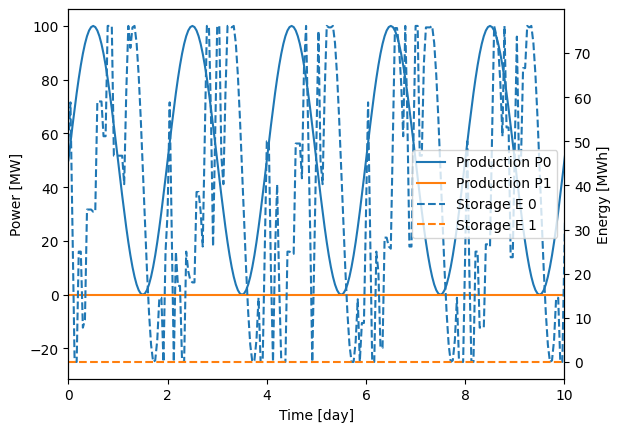

In [9]:
os.plot_powerflow()
plt.xlim([0, 10])

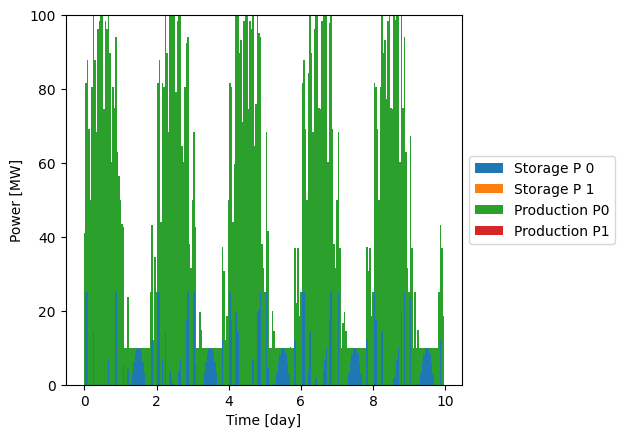

In [10]:
os.plot_powerout(xlim = [0, 10])